# Validation tests

In this notebook general validation tests for the potentials are performed.

In [1]:
%config IPCompleter.evaluation='unsafe'

In [2]:
from pyiron import Project
import numpy as np
from pyiron_atomistics.atomistics.structure.structurestorage import StructureStorage
from pyiron_atomistics.atomistics.structure.atoms import ase_to_pyiron, pyiron_to_ase
from helper import birch_murnaghan
from pychromatic import Multiplot
from pychromatic.colors import accent
import matplotlib.pyplot as plt
import pandas as pd
colors = {"g": "#1b9e77", "r": "#d95f02", "b": "#7570b3"}

/home/menon/miniconda3/envs/potentials_v0.0.2/lib/python3.11/site-packages/numpy/core/getlimits.py:542: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)
2024-04-05 20:57:53,753 - pyiron_log - WARNING - pyiron found a 'templates' folder in the /home/menon/pyiron/resources resource directory. These are no longer supported in pyiron_base >=0.7.0. They are replaced by Project.create_job_class() and Project.wrap_python_function().


In [3]:
pr = Project('validation_6')

In [4]:
store = StructureStorage()

Create and add fcc and bcc for Al and Li

In [5]:
s = pr.create.structure.bulk('Al', 'fcc', 4.04)
store.add_structure(s, identifier=f'Alfcc')

for lattice in ['fcc', 'bcc']:
    s = pr.create.structure.bulk('Li', lattice, 3.5)
    store.add_structure(s, identifier=f'Li{lattice}')

for lattice in ['AlLi', 'Al2Li3', 'Al3Li', 'Al4Li9']:
    s = pr.create.structure.ase.read(f'mp_structures/{lattice}.cif')
    store.add_structure(s, identifier=lattice)

In [6]:
potentials_list = ['AlLi-EAM', 'AlLi-HDNNP', 'AlLi-ACE']

## Energy-Volume curves

In [7]:
for pot in potentials_list:
    for i, structure in enumerate(store.iter_structures()):
        
        potname = pot.replace('-', '_')
        jobname = f'{potname}_{store.identifier[i]}'

        job_relax = pr.create.job.Lammps(jobname, delete_existing_job=True)
        job_relax.structure = structure
        job_relax.potential = pot
        job_relax.calc_minimize(pressure=0)
        job_relax.run()

        # Murnaghan
        job_ref = pr.create.job.Lammps(f"ref_job_{jobname}")
        job_ref.structure = job_relax.get_structure(-1)
        job_ref.potential = pot
        job_ref.calc_minimize()
        
        murn_job = job_ref.create_job(pr.job_type.Murnaghan, f"murn_job_{jobname}")
        murn_job.input["vol_range"] = 0.1
        murn_job.run()

The job AlLi_EAM_Alfcc was saved and received the ID: 7340
The job murn_job_AlLi_EAM_Alfcc was saved and received the ID: 7341
The job murn_job_AlLi_EAM_Alfcc_0_9 was saved and received the ID: 7342
The job murn_job_AlLi_EAM_Alfcc_0_92 was saved and received the ID: 7343
The job murn_job_AlLi_EAM_Alfcc_0_94 was saved and received the ID: 7344
The job murn_job_AlLi_EAM_Alfcc_0_96 was saved and received the ID: 7345
The job murn_job_AlLi_EAM_Alfcc_0_98 was saved and received the ID: 7346
The job murn_job_AlLi_EAM_Alfcc_1_0 was saved and received the ID: 7347
The job murn_job_AlLi_EAM_Alfcc_1_02 was saved and received the ID: 7348
The job murn_job_AlLi_EAM_Alfcc_1_04 was saved and received the ID: 7349
The job murn_job_AlLi_EAM_Alfcc_1_06 was saved and received the ID: 7350
The job murn_job_AlLi_EAM_Alfcc_1_08 was saved and received the ID: 7351
The job murn_job_AlLi_EAM_Alfcc_1_1 was saved and received the ID: 7352
The job AlLi_EAM_Lifcc was saved and received the ID: 7353
The job murn_j

In [8]:
pr.job_table()

,id,status,chemicalformula,job,subjob,projectpath,project,timestart,timestop,totalcputime,computer,hamilton,hamversion,parentid,masterid
0,7340,finished,Al,AlLi_EAM_Alfcc,/AlLi_EAM_Alfcc,None,/mnt/c/Users/menon/Documents/winrepos/projects-publication/potential_publication/03_validation/validation_6/,2024-04-05 20:57:57.051263,2024-04-05 20:57:57.488992,0.0,pyiron@cmleo26#1,Lammps,0.1,None,NaN
1,7341,finished,Al,murn_job_AlLi_EAM_Alfcc,/murn_job_AlLi_EAM_Alfcc,None,/mnt/c/Users/menon/Documents/winrepos/projects-publication/potential_publication/03_validation/validation_6/,2024-04-05 20:57:58.254327,2024-04-05 20:58:06.750478,8.0,pyiron@cmleo26#1#11/11,Murnaghan,0.3.0,None,NaN
2,7342,finished,Al,murn_job_AlLi_EAM_Alfcc_0_9,/murn_job_AlLi_EAM_Alfcc_0_9,None,/mnt/c/Users/menon/Documents/winrepos/projects-publication/potential_publication/03_validation/validation_6/murn_job_AlLi_EAM_Alfcc_hdf5/,2024-04-05 20:57:58.576493,2024-04-05 20:57:58.999537,0.0,pyiron@cmleo26#1,Lammps,0.1,None,7341.0
3,7343,finished,Al,murn_job_AlLi_EAM_Alfcc_0_92,/murn_job_AlLi_EAM_Alfcc_0_92,None,/mnt/c/Users/menon/Documents/winrepos/projects-publication/potential_publication/03_validation/validation_6/murn_job_AlLi_EAM_Alfcc_hdf5/,2024-04-05 20:57:59.292797,2024-04-05 20:57:59.711113,0.0,pyiron@cmleo26#1,Lammps,0.1,None,7341.0
4,7344,finished,Al,murn_job_AlLi_EAM_Alfcc_0_94,/murn_job_AlLi_EAM_Alfcc_0_94,None,/mnt/c/Users/menon/Documents/winrepos/projects-publication/potential_publication/03_validation/validation_6/murn_job_AlLi_EAM_Alfcc_hdf5/,2024-04-05 20:58:00.024480,2024-04-05 20:58:00.471288,0.0,pyiron@cmleo26#1,Lammps,0.1,None,7341.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268,7608,finished,Al4Li9,murn_job_AlLi_ACE_Al4Li9_1_02,/murn_job_AlLi_ACE_Al4Li9_1_02,None,/mnt/c/Users/menon/Documents/winrepos/projects-publication/potential_publication/03_validation/validation_6/murn_job_AlLi_ACE_Al4Li9_hdf5/,2024-04-05 21:01:54.954828,2024-04-05 21:01:55.896856,0.0,pyiron@cmleo26#1,Lammps,0.1,None,7601.0
269,7609,finished,Al4Li9,murn_job_AlLi_ACE_Al4Li9_1_04,/murn_job_AlLi_ACE_Al4Li9_1_04,None,/mnt/c/Users/menon/Documents/winrepos/projects-publication/potential_publication/03_validation/validation_6/murn_job_AlLi_ACE_Al4Li9_hdf5/,2024-04-05 21:01:56.258655,2024-04-05 21:01:57.103437,0.0,pyiron@cmleo26#1,Lammps,0.1,None,7601.0
270,7610,finished,Al4Li9,murn_job_AlLi_ACE_Al4Li9_1_06,/murn_job_AlLi_ACE_Al4Li9_1_06,None,/mnt/c/Users/menon/Documents/winrepos/projects-publication/potential_publication/03_validation/validation_6/murn_job_AlLi_ACE_Al4Li9_hdf5/,2024-04-05 21:01:57.455002,2024-04-05 21:01:58.334544,0.0,pyiron@cmleo26#1,Lammps,0.1,None,7601.0
271,7611,finished,Al4Li9,murn_job_AlLi_ACE_Al4Li9_1_08,/murn_job_AlLi_ACE_Al4Li9_1_08,None,/mnt/c/Users/menon/Documents/winrepos/projects-publication/potential_publication/03_validation/validation_6/murn_job_AlLi_ACE_Al4Li9_hdf5/,2024-04-05 21:01:58.669286,2024-04-05 21:01:59.544203,0.0,pyiron@cmleo26#1,Lammps,0.1,None,7601.0


Collect Murnaghan Jobs in a job table

In [9]:
def get_only_murn(job_table):
    return (job_table.hamilton == "Murnaghan") & (job_table.status == "finished") 

def get_volume(job_path):
    return job_path["output/volume"]/len(job_path["output/structure/positions"])

def get_eq_bm(job_path):
    return job_path["output/equilibrium_bulk_modulus"]

def get_eq_en(job_path):
    return job_path["output/equilibrium_energy"]

def get_potential(job_path):
    return "-".join(job_path.job_name.split("_")[2:4])

def get_compound(job_path):
    return job_path.job_name.split("_")[4]

def get_energy(job_path):
    return job_path["output/energy"]/len(job_path["output/structure/positions"])

def get_ase_atoms(job_path):
    return pyiron_to_ase(job_path.structure).copy()

In [12]:
table = pr.create_table("table_murn", delete_existing_job=True)
table.convert_to_object = True
table.db_filter_function = get_only_murn
table.add["potential"] = get_potential
table.add["compound"] = get_compound
table.add["volume"] = get_volume
table.add["bulk_modulus"] = get_eq_bm
table.add["energy_per_atom"] = get_energy
table.add["ase_atoms"] = get_ase_atoms

In [13]:
table.run()

The job table_murn was saved and received the ID: 7613


Loading and filtering jobs:   0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

/home/menon/miniconda3/envs/potentials_v0.0.2/lib/python3.11/site-packages/pyiron_base/jobs/datamining.py:651: FutureWarning: Starting with pandas version 3.0 all arguments of to_hdf except for the argument 'path_or_buf' will be keyword-only.
  self.pyiron_table._df.to_hdf(
/home/menon/miniconda3/envs/potentials_v0.0.2/lib/python3.11/site-packages/pyiron_base/jobs/datamining.py:651: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['potential', 'compound', 'volume', 'energy_per_atom', 'ase_atoms'], dtype='object')]

  self.pyiron_table._df.to_hdf(
/home/menon/miniconda3/envs/potentials_v0.0.2/lib/python3.11/site-packages/pyiron_base/jobs/datamining.py:651: FutureWarning: Starting with pandas version 3.0 all arguments of to_hdf except for the argument 'path_or_buf' will be keyword-only.
  self.pyiron_table._df.to_hdf(


In [14]:
df_murn = table.get_dataframe()

Read in DFT ref data

In [15]:
df_ref = pd.read_csv("dft_ref.csv")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


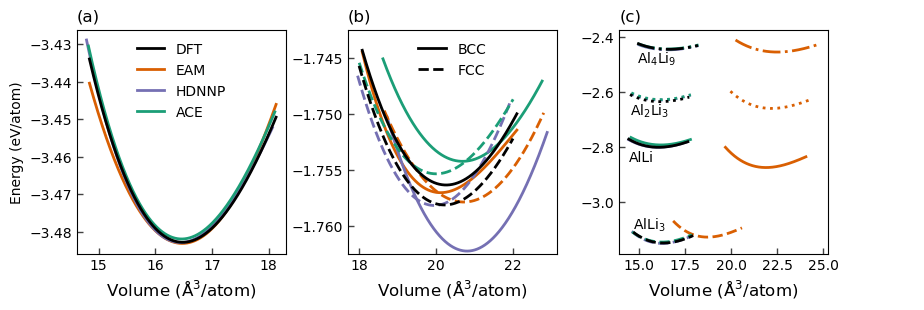

In [16]:
mlt = Multiplot(columns=3, width=700, ratio=0.3, wspace=0.3)

eam_vol, eam_en = birch_murnaghan(df_murn, "Alfcc", potential='AlLi-EAM')
hdn_vol, hdn_en = birch_murnaghan(df_murn, "Alfcc", potential='AlLi-HDNNP')
ace_vol, ace_en = birch_murnaghan(df_murn, "Alfcc", potential='AlLi-ACE')
dft_vol, dft_en = birch_murnaghan(df_ref, "Alfcc")

mlt[0,0].plot(dft_vol, dft_en, c='black', lw=2, label="DFT", zorder=10)
mlt[0,0].plot(eam_vol, eam_en, c=colors["r"], lw=2, label="EAM")
mlt[0,0].plot(hdn_vol, hdn_en, c=colors["b"], lw=2, label="HDNNP")
mlt[0,0].plot(ace_vol, ace_en, c=colors["g"], lw=2, label="ACE")

eam_vol, eam_en = birch_murnaghan(df_murn, "Libcc", potential='AlLi-EAM')
hdn_vol, hdn_en = birch_murnaghan(df_murn, "Libcc", potential='AlLi-HDNNP')
ace_vol, ace_en = birch_murnaghan(df_murn, "Libcc", potential='AlLi-ACE')
dft_vol, dft_en = birch_murnaghan(df_ref, "Libcc")

mlt[0,1].plot(dft_vol, dft_en, c='black', lw=2, label="BCC", zorder=10)
mlt[0,1].plot(eam_vol, eam_en, c=colors["r"], lw=2)
mlt[0,1].plot(hdn_vol, hdn_en, c=colors["b"], lw=2)
mlt[0,1].plot(ace_vol, ace_en, c=colors["g"], lw=2)

eam_vol, eam_en = birch_murnaghan(df_murn, "Lifcc", potential='AlLi-EAM')
hdn_vol, hdn_en = birch_murnaghan(df_murn, "Lifcc", potential='AlLi-HDNNP')
ace_vol, ace_en = birch_murnaghan(df_murn, "Lifcc", potential='AlLi-ACE')
dft_vol, dft_en = birch_murnaghan(df_ref, "Lifcc")

mlt[0,1].plot(dft_vol, dft_en, c='black', lw=2, label="FCC", zorder=10, ls='dashed')
mlt[0,1].plot(eam_vol, eam_en, c=colors["r"], lw=2, ls='dashed')
mlt[0,1].plot(hdn_vol, hdn_en, c=colors["b"], lw=2, ls='dashed')
mlt[0,1].plot(ace_vol, ace_en, c=colors["g"], lw=2, ls='dashed')

eam_vol, eam_en = birch_murnaghan(df_murn, "AlLi", potential='AlLi-EAM')
hdn_vol, hdn_en = birch_murnaghan(df_murn, "AlLi", potential='AlLi-HDNNP')
ace_vol, ace_en = birch_murnaghan(df_murn, "AlLi", potential='AlLi-ACE')
dft_vol, dft_en = birch_murnaghan(df_ref, "Al2Li2")

mlt[0,2].plot(dft_vol, dft_en, c='black', lw=2, zorder=10)
mlt[0,2].plot(eam_vol, eam_en, c=colors["r"], lw=2)
mlt[0,2].plot(hdn_vol, hdn_en, c=colors["b"], lw=2)
mlt[0,2].plot(ace_vol, ace_en, c=colors["g"], lw=2)
plt.text(min(dft_vol), min(dft_en)-0.05, r"AlLi")

eam_vol, eam_en = birch_murnaghan(df_murn, "Al3Li", potential='AlLi-EAM')
hdn_vol, hdn_en = birch_murnaghan(df_murn, "Al3Li", potential='AlLi-HDNNP')
ace_vol, ace_en = birch_murnaghan(df_murn, "Al3Li", potential='AlLi-ACE')
dft_vol, dft_en = birch_murnaghan(df_ref, "Al3Li")

mlt[0,2].plot(dft_vol, dft_en, c='black', lw=2, zorder=10, ls='dashed')
mlt[0,2].plot(eam_vol, eam_en, c=colors["r"], lw=2, ls='dashed')
mlt[0,2].plot(hdn_vol, hdn_en, c=colors["b"], lw=2, ls='dashed')
mlt[0,2].plot(ace_vol, ace_en, c=colors["g"], lw=2, ls='dashed')
plt.text(min(dft_vol), min(dft_en)+0.05, r"$\mathrm{AlLi}_3$")

eam_vol, eam_en = birch_murnaghan(df_murn, "Al4Li9", potential='AlLi-EAM')
hdn_vol, hdn_en = birch_murnaghan(df_murn, "Al4Li9", potential='AlLi-HDNNP')
ace_vol, ace_en = birch_murnaghan(df_murn, "Al4Li9", potential='AlLi-ACE')
dft_vol, dft_en = birch_murnaghan(df_ref, "Al4Li9")

mlt[0,2].plot(dft_vol, dft_en, c='black', lw=2, zorder=10, ls='dashdot')
mlt[0,2].plot(eam_vol, eam_en, c=colors["r"], lw=2, ls='dashdot')
mlt[0,2].plot(hdn_vol, hdn_en, c=colors["b"], lw=2, ls='dashdot')
mlt[0,2].plot(ace_vol, ace_en, c=colors["g"], lw=2, ls='dashdot')
plt.text(min(dft_vol), min(dft_en)-0.05, r"$\mathrm{Al_4Li_9}$")

eam_vol, eam_en = birch_murnaghan(df_murn, "Al2Li3", potential='AlLi-EAM')
hdn_vol, hdn_en = birch_murnaghan(df_murn, "Al2Li3", potential='AlLi-HDNNP')
ace_vol, ace_en = birch_murnaghan(df_murn, "Al2Li3", potential='AlLi-ACE')
dft_vol, dft_en = birch_murnaghan(df_ref, "Al2Li3")

mlt[0,2].plot(dft_vol, dft_en, c='black', lw=2, zorder=10, ls='dotted')
mlt[0,2].plot(eam_vol, eam_en, c=colors["r"], lw=2, ls='dotted')
mlt[0,2].plot(hdn_vol, hdn_en, c=colors["b"], lw=2, ls='dotted')
mlt[0,2].plot(ace_vol, ace_en, c=colors["g"], lw=2, ls='dotted')
plt.text(min(dft_vol), min(dft_en)-0.05, r"$\mathrm{Al_2Li_3}$")

mlt[0,0].legend(frameon=False)
mlt[0,1].legend(frameon=False)
mlt[0,2].legend(frameon=False, bbox_to_anchor=[1.45, 0.5])

mlt[0,0].set_xlabel(r"Volume ($\mathrm{\AA}^3/$atom)", fontsize=12)
mlt[0,1].set_xlabel(r"Volume ($\mathrm{\AA}^3/$atom)", fontsize=12)
mlt[0,2].set_xlabel(r"Volume ($\mathrm{\AA}^3/$atom)", fontsize=12)
mlt[0,0].set_ylabel(r"Energy (eV/atom)")
mlt[0,0].set_title(r"(a)", loc='left', fontsize=12)
mlt[0,1].set_title(r"(b)", loc='left', fontsize=12)
mlt[0,2].set_title(r"(c)", loc='left', fontsize=12)
mlt[0,1].set_ylim(-1.7625, -1.7425)
plt.savefig("img_ev_curve.png", dpi=300, bbox_inches='tight')

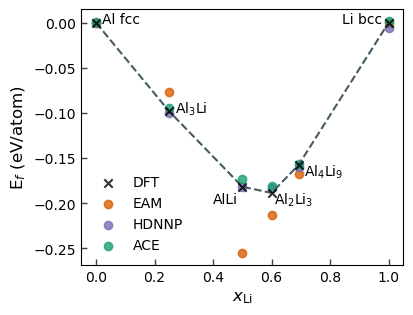

In [17]:
al_dft = min(birch_murnaghan(df_ref, "Alfcc")[1])
li_dft = min(birch_murnaghan(df_ref, "Libcc")[1])

c0 = 0
s0_dft = min(birch_murnaghan(df_ref, "Alfcc")[1]) - ((1-c0)*al_dft + c0*li_dft) 
s0_eam = min(birch_murnaghan(df_murn, "Alfcc", potential='AlLi-EAM')[1]) - ((1-c0)*al_dft + c0*li_dft)
s0_hdn = min(birch_murnaghan(df_murn, "Alfcc", potential='AlLi-HDNNP')[1]) - ((1-c0)*al_dft + c0*li_dft)
s0_ace = min(birch_murnaghan(df_murn, "Alfcc", potential='AlLi-ACE')[1]) - ((1-c0)*al_dft + c0*li_dft)

c1 = 1/(1+3)
s1_dft = min(birch_murnaghan(df_ref, "Al3Li")[1]) - ((1-c1)*al_dft + c1*li_dft) 
s1_eam = min(birch_murnaghan(df_murn, "Al3Li", potential='AlLi-EAM')[1]) - ((1-c1)*al_dft + c1*li_dft)
s1_hdn = min(birch_murnaghan(df_murn, "Al3Li", potential='AlLi-HDNNP')[1]) - ((1-c1)*al_dft + c1*li_dft)
s1_ace = min(birch_murnaghan(df_murn, "Al3Li", potential='AlLi-ACE')[1]) - ((1-c1)*al_dft + c1*li_dft)

c2 = 1/(1+1)
s2_dft = min(birch_murnaghan(df_ref, "Al2Li2")[1]) - ((1-c2)*al_dft + c2*li_dft) 
s2_eam = min(birch_murnaghan(df_murn, "AlLi", potential='AlLi-EAM')[1]) - ((1-c2)*al_dft + c2*li_dft)
s2_hdn = min(birch_murnaghan(df_murn, "AlLi", potential='AlLi-HDNNP')[1]) - ((1-c2)*al_dft + c2*li_dft)
s2_ace = min(birch_murnaghan(df_murn, "AlLi", potential='AlLi-ACE')[1]) - ((1-c2)*al_dft + c2*li_dft)

c3 = 3/(3+2)
s3_dft = min(birch_murnaghan(df_ref, "Al2Li3")[1]) - ((1-c3)*al_dft + c3*li_dft) 
s3_eam = min(birch_murnaghan(df_murn, "Al2Li3", potential='AlLi-EAM')[1]) - ((1-c3)*al_dft + c3*li_dft)
s3_hdn = min(birch_murnaghan(df_murn, "Al2Li3", potential='AlLi-HDNNP')[1]) - ((1-c3)*al_dft + c3*li_dft)
s3_ace = min(birch_murnaghan(df_murn, "Al2Li3", potential='AlLi-ACE')[1]) - ((1-c3)*al_dft + c3*li_dft)

c4 = 9/(4+9)
s4_dft = min(birch_murnaghan(df_ref, "Al4Li9")[1]) - ((1-c4)*al_dft + c4*li_dft) 
s4_eam = min(birch_murnaghan(df_murn, "Al4Li9", potential='AlLi-EAM')[1]) - ((1-c4)*al_dft + c4*li_dft)
s4_hdn = min(birch_murnaghan(df_murn, "Al4Li9", potential='AlLi-HDNNP')[1]) - ((1-c4)*al_dft + c4*li_dft)
s4_ace = min(birch_murnaghan(df_murn, "Al4Li9", potential='AlLi-ACE')[1]) - ((1-c4)*al_dft + c4*li_dft)

c5 = 1
s5_dft = min(birch_murnaghan(df_ref, "Libcc")[1]) - ((1-c5)*al_dft + c5*li_dft) 
s5_eam = min(birch_murnaghan(df_murn, "Libcc", potential='AlLi-EAM')[1]) - ((1-c5)*al_dft + c5*li_dft) 
s5_hdn = min(birch_murnaghan(df_murn, "Libcc", potential='AlLi-HDNNP')[1]) - ((1-c5)*al_dft + c5*li_dft) 
s5_ace = min(birch_murnaghan(df_murn, "Libcc", potential='AlLi-ACE')[1]) - ((1-c5)*al_dft + c5*li_dft) 

mlt = Multiplot(width=300, ratio=0.8, )#wspace=0.3)

a=0.8
mlt[0,0].scatter([c0, c1, c2, c3, c4, c5], [s0_dft, s1_dft, s2_dft, s3_dft, s4_dft, s5_dft], c='black', marker='x', alpha=a, label='DFT', zorder=10)
mlt[0,0].scatter([c0, c1, c2, c3, c4, c5], [s0_eam, s1_eam, s2_eam, s3_eam, s4_eam, s5_eam], c=colors["r"], alpha=a, label='EAM')
mlt[0,0].scatter([c0, c1, c2, c3, c4, c5], [s0_hdn, s1_hdn, s2_hdn, s3_hdn, s4_hdn, s5_hdn], c=colors["b"], alpha=a, label='HDNNP')
mlt[0,0].scatter([c0, c1, c2, c3, c4, c5], [s0_ace, s1_ace, s2_ace, s3_ace, s4_ace, s5_ace], c=colors["g"], alpha=a, label='ACE')

mlt[0,0].plot([0, c1, c2, c3, c4, 1], [0, s1_dft, s2_dft, s3_dft, s4_dft, 0], c=accent['lgrey'], ls='dashed')
mlt[0,0].legend(frameon=False)
mlt[0,0].set_xlabel(r"$x_\mathrm{Li}$",fontsize="12")
mlt[0,0].set_ylabel(r"E$_f$ (eV/atom)",fontsize="12")

plt.text(0.02, -0.00, 'Al fcc')
plt.text(0.27, -0.10, r'Al$_3$Li')
plt.text(0.4, -0.20, r'AlLi')
plt.text(0.61, -0.20, r'Al$_2$Li$_3$')
plt.text(0.71, -0.17, r'Al$_4$Li$_9$')
plt.text(0.84, -0.00, 'Li bcc')
plt.savefig("img_convex_hull.png", dpi=300, bbox_inches='tight')

## Elastic constants and phonons

In [18]:
list_of_phases = ['Alfcc', 'Libcc', 'AlLi', 'Al3Li']

In [19]:
potentials_list = ['AlLi-EAM', 'AlLi-HDNNP', 'AlLi-ACE']

In [20]:
subset_murn = df_murn[df_murn["compound"].isin(list_of_phases)]
subset_murn

,job_id,potential,compound,volume,bulk_modulus,energy_per_atom,ase_atoms
0,7341,AlLi-EAM,Alfcc,"[14.8363688708736, 15.1660659567673, 15.495763042684, 15.8254601294124, 16.1551572151754, 16.4848543013555, 16.8145513873762, 17.1442484735571, 17.4739455588196, 17.8036426449814, 18.1333397313917]",77.547271,"[-3.44043910753599, -3.45636557949121, -3.46830407475773, -3.47664051111696, -3.48156902364589, -3.48319079969745, -3.4815905203321, -3.47684676488006, -3.46915717952562, -3.45882355678429, -3.446...","(Atom('Al', [0.0, 0.0, 0.0], index=0))"
2,7367,AlLi-EAM,Libcc,"[18.0892156248549, 18.491198194608, 18.8931807638332, 19.2951633336874, 19.6971459028195, 20.0991284721866, 20.5011110416446, 20.9030936111414, 21.3050761801847, 21.7070587501988, 22.1090413194466]",14.297189,"[-1.7444922601482, -1.74938298319342, -1.75298221941573, -1.75536209594002, -1.75665203594723, -1.75703587503148, -1.75672040759058, -1.75589345766041, -1.75469437520406, -1.7531979175031, -1.7514...","(Atom('Li', [0.0, 0.0, 0.0], index=0))"
3,7380,AlLi-EAM,AlLi,"[19.6772272067051, 20.11449892228605, 20.551770638258674, 20.98904235346135, 21.426314069348926, 21.863585784814823, 22.30085750062815, 22.7381292165001, 23.17540093212325, 23.61267264797485, 24.0...",81.909721,"[-2.801698688120625, -2.8296262986299, -2.8506356337408, -2.8647588366097, -2.872567592747375, -2.874951798680125, -2.87288817027815, -2.867278615672275, -2.8588733838069, -2.84824558599005, -2.83...","(Atom('Li', [4.982325840580394, 2.8765471652483536, 2.034026006950323], index=0), Atom('Li', [7.473488760872885, 4.314820747870893, 3.051039010425718], index=1), Atom('Al', [-4.53145385072325e-12,..."
5,7406,AlLi-EAM,Al3Li,"[16.8340575382535, 17.208147705547425, 17.5822378734719, 17.956328040840475, 18.330418208488474, 18.704508375963, 19.0785985430386, 19.45268871072695, 19.826778878438226, 20.200869045487675, 20.57...",79.201150,"[-3.068891829462075, -3.091867301338125, -3.10857349298395, -3.119670168133875, -3.125843200939175, -3.12775893654505, -3.126045092554625, -3.121285893988325, -3.1140350879436, -3.104828018475375,...","(Atom('Li', [0.0, 0.0, 0.0], index=0), Atom('Al', [2.106874987963487, 2.106874987963487, 2.5801777102131027e-16], index=1), Atom('Al', [2.106874987963487, 1.2900888551065513e-16, 2.106874987963487..."
7,7432,AlLi-HDNNP,Alfcc,"[14.7844369986873, 15.1129800431741, 15.4415230877719, 15.7700661326599, 16.0986091765434, 16.4271522212171, 16.7556952660949, 17.0842383101026, 17.4127813541843, 17.7413243988353, 18.0698674433377]",81.871545,"[-3.42883019411612, -3.44966681243128, -3.46506833912315, -3.47540988974585, -3.48099961494182, -3.48247523414493, -3.48113654216857, -3.47724770731332, -3.47098304555864, -3.46250426822479, -3.45...","(Atom('Al', [0.0, 0.0, 0.0], index=0))"
9,7458,AlLi-HDNNP,Libcc,"[18.7338133706751, 19.1501203343341, 19.5664272979677, 19.9827342625134, 20.3990412258928, 20.8153481897849, 21.2316551536355, 21.6479621174349, 22.0642690808152, 22.4805760449156, 22.8968830090855]",17.383310,"[-1.75041112664235, -1.75459152777934, -1.75794405113621, -1.76040426016656, -1.76190608783334, -1.76240864268144, -1.76191653584307, -1.76048859300647, -1.75823274524003, -1.75528869795896, -1.75...","(Atom('Li', [0.0, 0.0, 0.0], index=0))"
10,7471,AlLi-HDNNP,AlLi,"[14.4161900505721, 14.7365498296453, 15.056909608284025, 15.377269386905425, 15.6976291662897, 16.0179889449439, 16.338348724077125, 16.658708503125524, 16.97906828191155, 17.299428060834924, 17.6...",48.298715,"[-2.7733952994315, -2.7841690812841, -2.79204332179995, -2.797314019399275, -2.8002721164528, -2.8012013883324, -2.80028253611975, -2.79764462479735, -2.793443329967125, -2.78780532595165, -2.7808...","(Atom('Li', [4.491530222077653, 2.593186182789802, 1.833659534730102], index=0), Atom('Li', [6.737295333119004, 3.88977927418323, 2.7504893020947363], index=1), Atom('Al', [-3.0628193733628833e-12..."
12,7497,AlLi-HDNNP,Al3Li,"[14.581924032407924, 14.905966788334625, 15.230009544416674, 15.5540523007093, 1

In [21]:
for pot in potentials_list:       
    potname = pot.replace('-', '_')
    pr_pot = pr.create_group(potname)

    for _, row in subset_murn[subset_murn.potential==pot].iterrows():
        job_id = row["job_id"]
        
        ref = pr.load(job_id)
        phase = ref.name.split('_')[-1]
        job_ref = pr.create.job.Lammps(f'ref_job_{potname}_{phase}')
        
        job_ref.structure = ref.structure
        job_ref.potential = pot
        job_ref.calc_minimize()

        elastic_job = job_ref.create_job(pr.job_type.ElasticMatrixJob, f'elastic_job_{potname}_{phase}')
        elastic_job.input["eps_range"] = 0.05
        elastic_job.run(delete_existing_job=True)

        phonopy_job = job_ref.create_job(pr.job_type.PhonopyJob, f"phonopy_job_{potname}_{phase}")
        job_ref.calc_static()
        phonopy_job.run()

The job elastic_job_AlLi_EAM_Alfcc was saved and received the ID: 7614
The job s_e_0 was saved and received the ID: 7615
The job s_01_e_m0_05000 was saved and received the ID: 7616
The job s_01_e_m0_02500 was saved and received the ID: 7617
The job s_01_e_0_02500 was saved and received the ID: 7618
The job s_01_e_0_05000 was saved and received the ID: 7619
The job s_08_e_m0_05000 was saved and received the ID: 7620
The job s_08_e_m0_02500 was saved and received the ID: 7621
The job s_08_e_0_02500 was saved and received the ID: 7622
The job s_08_e_0_05000 was saved and received the ID: 7623
The job s_23_e_m0_05000 was saved and received the ID: 7624
The job s_23_e_m0_02500 was saved and received the ID: 7625
The job s_23_e_0_02500 was saved and received the ID: 7626
The job s_23_e_0_05000 was saved and received the ID: 7627
The job phonopy_job_AlLi_EAM_Alfcc was saved and received the ID: 7628
The job ref_job_AlLi_EAM_Alfcc_0 was saved and received the ID: 7629
The job elastic_job_AlLi_

In [22]:
def filter_elastic(job_table):
    return (job_table.hamilton == "ElasticMatrixJob") & (job_table.status == "finished")

# Get corresponding elastic constants
def get_c11(job_path):
    return job_path["output/elasticmatrix"]["C"][0, 0]

def get_c12(job_path):
    return job_path["output/elasticmatrix"]["C"][0, 1]

def get_c44(job_path):
    return job_path["output/elasticmatrix"]["C"][3, 3]

In [23]:
table = pr.create_table("table_elastic", delete_existing_job=True)
table.db_filter_function = filter_elastic
table.add["potential"] = get_potential
table.add["C11"] = get_c11
table.add["C12"] = get_c12
table.add["C44"] = get_c44
table.add["compound"] = get_compound

table.run()

The job table_elastic was saved and received the ID: 7812


Loading and filtering jobs:   0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

/home/menon/miniconda3/envs/potentials_v0.0.2/lib/python3.11/site-packages/pyiron_base/jobs/datamining.py:651: FutureWarning: Starting with pandas version 3.0 all arguments of to_hdf except for the argument 'path_or_buf' will be keyword-only.
  self.pyiron_table._df.to_hdf(


In [24]:
data_elastic = table.get_dataframe()
data_elastic

,job_id,potential,C11,C12,C44,compound
0,7614,AlLi-EAM,98.072058,66.458423,46.128769,Alfcc
1,7630,AlLi-EAM,14.905778,14.365771,11.504125,Libcc
2,7646,AlLi-EAM,130.928772,50.341046,25.279659,AlLi
3,7663,AlLi-EAM,97.232783,67.752767,22.146522,Al3Li
4,7680,AlLi-HDNNP,131.302431,60.673238,39.675004,Alfcc
5,7696,AlLi-HDNNP,20.316896,13.228469,14.603524,Libcc
6,7712,AlLi-HDNNP,117.765522,15.370614,45.476823,AlLi
7,7729,AlLi-HDNNP,121.147870,44.508678,43.009411,Al3Li
8,7746,AlLi-ACE,130.390756,61.022690,39.354664,Alfcc
9,7762,AlLi-ACE,13.107614,12.416830,10.918415,Libcc


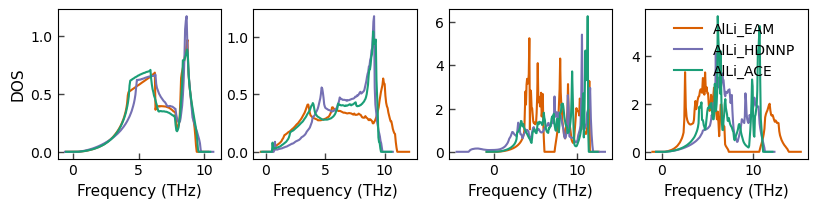

In [30]:
mlt = Multiplot(columns=4, rows=1, width=700, ratio=0.2, )#wspace=0.3)
clrlist = [colors["r"], colors["b"], colors["g"]]

phases = ['Alfcc', 'Libcc', 'AlLi', 'Al3Li']
potnames = ['AlLi_EAM', 'AlLi_HDNNP', 'AlLi_ACE']

for cp, phase in enumerate(phases):
    for count, potname in enumerate(potnames):
        phonopy_job = pr[f"phonopy_job_{potname}_{phase}"]
        thermo = phonopy_job.get_thermal_properties(t_min=0, t_max=800)
        mlt[0,cp].plot(phonopy_job["output/dos_energies"], phonopy_job["output/dos_total"], 
                lw=1.5,
                color=clrlist[count], 
                label=potname,)

        mlt[0,cp].set_xlabel("Frequency (THz)",fontsize=11)
mlt[0,0].set_ylabel("DOS",fontsize=11)
plt.legend(frameon=False)
plt.savefig("img_dos.png", dpi=300, bbox_inches='tight')